In [1]:
## Alistair Duffey, Feb 26

# G6-1.5K- cloud data workflow example
............

notebook reads in data G6-1.5K-SAI and -HiLLA simulations from Reflective Cloud Hub S3 buckets, across four models, to plot a summary of SO2 injection and temperature impacts 

............

It produces a summary plot for Visioni et al., 2026 (The Geoengineering Model Intercomparison Project (GeoMIP)
contribution to CMIP7)

............

Runs on the Reflective CLoud Hub, and requires (1) Utils.py (2) prior re-gridding of E3SM data (see steps in Regrid_E3SM_data.ipynb - also stored on the Cloud Hub under /shared/testing/Regrid_E3SM_data_test_AD.ipynb)

In [1]:
## packages for cloud data intake: 
import s3fs
import fsspec

## packages for analysis
import pandas as pd
import xarray as xr
import dask
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import os
from Utils import weighted_annual_resample, spatial_mean, set_time_to_center_of_bounds
from Config import colours

In [2]:
### file paths

miroc_base, miroc_members = 's3://reflective-persistent-prod-large/MIROC-ES2H/', ['r01', 'r02', 'r03']

ukesm_HiLLA_base, ukesm_HiLLA_members = 's3://reflective-persistent-prod-large/UKESM1-1/G6-1p5K-HiLLA/', ['r12i1p1f2', 'r2i1p1f2', 'r3i1p1f2']
cesm_HiLLA_base, cesm_HiLLA_members = 's3://reflective-persistent-prod-large/CESM2-WACCM/G6-1.5k-HiLLA/', ['r1', 'r2', 'r3']
#e3sm_HiLLA_base, e3sm_HiLLA_members = 's3://reflective-persistent-prod/alistairduffey/E3SMv3/regridded_combined/', ['v3.LR.ssp245.g6_hilla.sai.0101', 'v3.LR.ssp245.g6_hilla.sai.0151', 'v3.LR.ssp245.g6_hilla.sai.0201']

cesm_SAI_base, cesm_SAI_members = 's3://reflective-persistent-prod/alistairduffey/CESM2-WACCM/G6-1.5K-SAI/', ['r1', 'r2', 'r3']
ukesm_SAI_base, ukesm_SAI_members = 's3://reflective-persistent-prod/alistairduffey/UKESM1-1/G6-1.5K-SAI/', ['r1', 'r2', 'r3']
e3sm_SAI_base, e3sm_SAI_members = 's3://reflective-persistent-prod/alistairduffey/E3SMv3/G6-1.5K-SAI/', ['r1', 'r2', 'r3']

table='AMON'

miroc_G6HiLLA_T_files = [miroc_base + 'G6-1.5K-HiLLA/Amon/' + 'tas_G6-1.5K-HiLLA_{}.nc'.format(member) for member in miroc_members]
miroc_G6SAI_T_files = [miroc_base + 'G6-1.5K-SAI/Mon/' + 'SurfT_G6-1.5K-SAI_{}.nc'.format(member) for member in miroc_members]
miroc_ssp245_T_files = [miroc_base + 'G6-1.5K-HiLLA/Amon/' + 'tas_baseline_{}.nc'.format(member) for member in miroc_members]

e3sm_G6SAI_files = [
    's3://reflective-persistent-prod/alistairduffey/E3SMv3/G6-1.5K-SAI/r1/tas/E3SM_v3.LR.ssp245.0101.g6.sai.TREFHT.203501-208412.nc',
    's3://reflective-persistent-prod/alistairduffey/E3SMv3/G6-1.5K-SAI/r2/tas/E3SM_v3.LR.ssp245.0151.g6.sai.TREFHT.203501-208412.nc',
    's3://reflective-persistent-prod/alistairduffey/E3SMv3/G6-1.5K-SAI/r3/tas/E3SM_v3.LR.ssp245.0201.g6.sai.TREFHT.203501-208412.nc'
]

e3sm_HiLLA_base = 's3://reflective-persistent-prod/alistairduffey/E3SMv3/regridded_combined/'
e3sm_HiLLA_members = ['v3.LR.ssp245.g6_hilla.sai.0101/regridded_TREFHT_203501_203912.nc',
                      'v3.LR.ssp245.g6_hilla.sai.0151/regridded_TREFHT_203501_203912.nc', 
                      'v3.LR.ssp245.g6_hilla.sai.0201/regridded_TREFHT_203501_203912.nc']


e3sm_ssp245_members = ['v3.LR.ssp245_0101/regridded_TREFHT_201501_201912.nc',
                       'v3.LR.ssp245_0151/regridded_TREFHT_201501_201912.nc',
                       'v3.LR.ssp245_0201/regridded_TREFHT_201501_201912.nc']

### Read in all the data

We need to read in data formatted in various different ways, from various different places. The following set of cells do that. I have split this code up across many cells for easier debugging, it is not fast - takes a couple of minutes, and a few GB of memory. We read in 3 members each for 4 models, for 3 scenarios (SSP2-4.5, G6-1.5K-HiLLA and G6-1.5K-SAI), for near-surface air temp. data

In [4]:
 
## func to read in datasets to a list
def read_in_all_members_to_ds_list(input_file_paths_for_members, renamevar=None):
    ds_list = []  
    for s3_path in input_file_paths_for_members:
        # Open the dataset directly from the S3 URL using xarray
        with fsspec.open(s3_path, mode='rb') as file:
            ds = xr.open_dataset(file, 
                                 engine="h5netcdf", 
                                 chunks={}).load() # load to avoid "I/O on closed file" error later on - can we avoid loading here?
        if renamevar:
            ds = ds.rename({renamevar:'tas'}) # for consistency with others
        ds = set_time_to_center_of_bounds(ds, time_bounds_name='time_bnds') # for CESM G6 data, monthly files are labelled by end of month not centre by default (why?!). This function sets t to centre of t_bounds
        ds_list.append(ds) 
    return ds_list


In [5]:
### read in CESM data for SAI scenarios

# cesm_r1_G6HiLLA_T_file = .. ### cesm_r1 file not there for TREFHT ??? 
cesm_G6HiLLA_T_files = [cesm_HiLLA_base+cesm_HiLLA_members[i] + '/' + table + '/b.e21.BW.f09_g17.SSP245-G6-1p5K-HiLLA.00{}.cam.h0.TREFHT.203501-208412.nc'.format(str(i+1)) for i in [1, 2]]

# apply for the cesm HiLLA case, takes a couple minutes becuase we are loading data into memory at this stage
cesm_G6HiLLA_T_datasets = read_in_all_members_to_ds_list(cesm_G6HiLLA_T_files, renamevar='TREFHT')

## repeat the above for the CESM G6SAI data: 

cesm_G6SAI_T_files = [cesm_SAI_base+cesm_SAI_members[i] + '/' + table + '/CESM_b.e21.BW.f09_g17.SSP245-G6-1p5K-SAI.00{}.cam.h0.TREFHT.203501-208412.nc'.format(str(i+1)) for i in [0, 1, 2]]
 
# apply for the cesm SAI case
cesm_G6SAI_T_datasets = read_in_all_members_to_ds_list(cesm_G6SAI_T_files, renamevar='TREFHT')

In [6]:
## read in the miroc T data
miroc_G6HiLLA_T_datasets = read_in_all_members_to_ds_list(miroc_G6HiLLA_T_files)
miroc_G6SAI_T_datasets = read_in_all_members_to_ds_list(miroc_G6SAI_T_files, renamevar='SurfT')
miroc_ssp245_T_datasets = read_in_all_members_to_ds_list(miroc_ssp245_T_files)

In [7]:
## read in the UKESM G6-HiLLA data:

# different structure - multiple ncs in a base level directory for a given variable

ukesm_G6HiLLA_paths = [ukesm_HiLLA_base+ukesm_HiLLA_members[i] + '/apm/Amon/tas/' for i in [0, 1, 2]]
ukesm_G6SAI_files = [ukesm_SAI_base+ukesm_SAI_members[i] + '/AMON/' + 'UKESM_T1.5m_G6-1p5K-SAI.00{}.nc'.format(i+1) for i in [0, 1, 2]]

In [38]:
## define another read in function for UKESM G6-1.5K-SAI data as it has some weird features (the data sourced via Lee et al.'s zenodo does anyway)
def read_in_all_members_to_ds_list_UKESM_from_paths(path_list, SAI_rename_time_dims=False):
    """ input: list of paths to bottom level directory for UKESM data on AWS bucket
        output: list of opened datasets, each contianing the single merged dataset from multiple time-split .ncs
    """
    ds_list = []
    for path in path_list:
        files = fsspec.open_files(f"{path}*.nc", mode='rb')
        ds = xr.open_mfdataset([file.open() for file in files], #don't specify engine here as the .ncs for G6SAI are weirdly formatted
                       combine="nested", concat_dim="time", chunks={}).load()
        if SAI_rename_time_dims:
            ds = ds.isel(time=0).rename({'t':'time'}) # manual step to fix weird time dims
            ds = ds.rename({'temp':'tas'}) # for consistency with others
            ds = ds.isel(ht=0) # also get rid of the ht dimension which confuses things
        ds_list.append(ds)
    return ds_list

def read_in_all_members_to_ds_list_UKESM_from_files(file_list, SAI_rename_time_dims=False, rename_TREFHT=False):
    """ input: list of file paths for UKESM data on AWS bucket
        output: list of opened datasets, each contianing the single merged dataset from multiple time-split .ncs
    """
    ds_list = []
    for f in file_list:
        with fsspec.open(f, mode='rb') as file:
            ds = xr.open_dataset(file, 
                                 #engine="h5netcdf", 
                                 chunks={}).load()
        if SAI_rename_time_dims:
            ds = ds.rename({'t':'time'}) # manual step to fix weird time dims
            ds = ds.rename({'temp':'tas'}) # for consistency with others
            ds = ds.isel(ht=0) # also get rid of the ht dimension which confuses things
        
        if rename_TREFHT:
            ds = ds.rename({'TREFHT':'tas'})

        ds_list.append(ds)
    return ds_list


In [9]:
# read in the UKESM data
ukesm_G6HiLLA_T_datasets = read_in_all_members_to_ds_list_UKESM_from_paths(ukesm_G6HiLLA_paths)
ukesm_G6SAI_T_datasets = read_in_all_members_to_ds_list_UKESM_from_files(ukesm_G6SAI_files, SAI_rename_time_dims=True)

In [39]:
# read in the E3SM data

e3sm_G6SAI_T_datasets = read_in_all_members_to_ds_list_UKESM_from_files(e3sm_G6SAI_files, 
                                                                        SAI_rename_time_dims=False,
                                                                        rename_TREFHT=True)

In [34]:
## repeat for E3SM

## test reading in one of the combined regridded files on persistent-prod
e3sm_G6HiLLA_T_datasets = []
for s3_path in [e3sm_HiLLA_base+e3sm_HiLLA_members[i] for i in [0,1,2]]:
    # Open the dataset directly from the S3 URL using xarray
    with fsspec.open(s3_path, mode='rb') as file:
        ds = xr.open_dataset(file, engine="h5netcdf", chunks={}).load()
        ds = ds.rename({'TREFHT':'tas'})
        e3sm_G6HiLLA_T_datasets.append(ds)
e3sm_G6HiLLA_T_datasets

## repeat the above for the ssp245 data which is formatted as for the HiLLA 
e3sm_ssp245_T_datasets = []
for s3_path in [e3sm_HiLLA_base+e3sm_ssp245_members[i] for i in [0,1,2]]:
    # Open the dataset directly from the S3 URL using xarray
    with fsspec.open(s3_path, mode='rb') as file:
        ds = xr.open_dataset(file, engine="h5netcdf", chunks={}).load()
        ds = ds.rename({'TREFHT':'tas'})
        e3sm_ssp245_T_datasets.append(ds)
#e3sm_ssp245_T_datasets

In [35]:
## read in SSP245 for CESM from the AWS CMIP store

# Connect to AWS S3 storage
fs = s3fs.S3FileSystem(anon=True)

# load catalogue
df = pd.read_csv("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.csv")

# subset the archive
df_subset = df.query("activity_id=='ScenarioMIP' & source_id=='CESM2-WACCM' & experiment_id=='ssp245' & table_id=='Amon' & variable_id=='tas'")

# get the path to a specific zarr store
#df_subset

# make a list of datasets for 3 CESM tas ssp245 members
cesm_ssp245_T_datasets = []

for i in range(3):
    zstore = df_subset.zstore.values[i]
    zstore
    
    ds = xr.open_dataset(
        zstore,
        engine="zarr",
        consolidated=True,
        chunks={},                        # or {} / None or 'auto' as you prefer
        storage_options={"anon": True},       # anonymous S3 access
    )
    cesm_ssp245_T_datasets.append(ds)
#cesm_ssp245_T_datasets

In [13]:
### also get UKESM SSP2-4.5 - this one is pulled from our bucket, as we need to use the recent version of the model

ukesm_ssp245_base, ukesm_ssp245_members = 's3://reflective-persistent-prod-large/UKESM1-1/SSP245/', ['r12i1p1f1', 'r2i1p1f1', 'r3i1p1f1']
ukesm_ssp245_paths = [ukesm_ssp245_base+ukesm_ssp245_members[i] + '/ap5/Amon/tas/' for i in [0, 1, 2]]
ukesm_ssp245_T_datasets = read_in_all_members_to_ds_list_UKESM_from_paths(ukesm_ssp245_paths)

In [14]:
## now reduce to annual time series of global T and plot

In [15]:
def global_annual_mean_timeseries(ds_list, var='tas', region='Global', 
                                  lat_name='lat', lon_name='lon',
                                  drop_2084=False, miroc=None):
    """ make a list of datasets containing global and annual 
        means of a list of lat-lon-time datasets """
    
    out_ds_list = []
    for ds in ds_list:
        
        if drop_2084:
            ds = ds.sel(time=(ds.time.dt.year != 2084)) # hack to fix UKESM data which is missing Dec 2084
        if miroc:
            ds = ds.sortby(lat_name) # fix descending latitudes
        global_mean_tas = spatial_mean(ds, var=var, region=region, lat_name=lat_name, lon_name=lon_name)
        global_annual_mean_tas = weighted_annual_resample(global_mean_tas, var=var)
        
        out_ds_list.append(global_annual_mean_tas)
        
    return out_ds_list



In [40]:
cesm_ssp245_T_global_annual_mean_timeseries = global_annual_mean_timeseries(cesm_ssp245_T_datasets)
cesm_G6SAI_T_global_annual_mean_timeseries = global_annual_mean_timeseries(cesm_G6SAI_T_datasets)
cesm_G6HiLLA_T_global_annual_mean_timeseries = global_annual_mean_timeseries(cesm_G6HiLLA_T_datasets)

ukesm_ssp245_T_global_annual_mean_timeseries = global_annual_mean_timeseries(ukesm_ssp245_T_datasets)
ukesm_G6SAI_T_global_annual_mean_timeseries = global_annual_mean_timeseries(ukesm_G6SAI_T_datasets, 
                                                lat_name='latitude', lon_name='longitude')
ukesm_G6HiLLA_T_global_annual_mean_timeseries = global_annual_mean_timeseries(ukesm_G6HiLLA_T_datasets, 
                                                                              drop_2084=True)

miroc_ssp245_T_global_annual_mean_timeseries = global_annual_mean_timeseries(miroc_ssp245_T_datasets, miroc=True)
miroc_G6SAI_T_global_annual_mean_timeseries = global_annual_mean_timeseries(miroc_G6SAI_T_datasets, miroc=True)
miroc_G6HiLLA_T_global_annual_mean_timeseries = global_annual_mean_timeseries(miroc_G6HiLLA_T_datasets, miroc=True)

e3sm_ssp245_T_global_annual_mean_timeseries = global_annual_mean_timeseries(e3sm_ssp245_T_datasets)
e3sm_G6SAI_T_global_annual_mean_timeseries = global_annual_mean_timeseries(e3sm_G6SAI_T_datasets)
e3sm_G6HiLLA_T_global_annual_mean_timeseries = global_annual_mean_timeseries(e3sm_G6HiLLA_T_datasets)

timeseries_dict = {'CESM2-WACCM':{'SSP2-4.5':cesm_ssp245_T_global_annual_mean_timeseries,
                                  'G6-1.5K-SAI':cesm_G6SAI_T_global_annual_mean_timeseries,
                                  'G6-1.5K-HiLLA':cesm_G6HiLLA_T_global_annual_mean_timeseries},
                   'UKESM1-1':{'SSP2-4.5':ukesm_ssp245_T_global_annual_mean_timeseries,
                               'G6-1.5K-SAI':ukesm_G6SAI_T_global_annual_mean_timeseries,
                               'G6-1.5K-HiLLA':ukesm_G6HiLLA_T_global_annual_mean_timeseries},
                   'MIROC-ES2H':{'SSP2-4.5':miroc_ssp245_T_global_annual_mean_timeseries,
                               'G6-1.5K-SAI':miroc_G6SAI_T_global_annual_mean_timeseries,
                               'G6-1.5K-HiLLA':miroc_G6HiLLA_T_global_annual_mean_timeseries},
                   'E3SMv3':{'SSP2-4.5':e3sm_ssp245_T_global_annual_mean_timeseries,
                               'G6-1.5K-SAI':e3sm_G6SAI_T_global_annual_mean_timeseries,
                               'G6-1.5K-HiLLA':e3sm_G6HiLLA_T_global_annual_mean_timeseries}}

### Get injection magnitudes
For the final plot, we also need injection magnitudes. Again, these are formatted differently for different models, the code below reads in from various file types, and converts them all to the same format pandas dataframes. 

In [42]:
## also read in injection logs - i put a copy of these small files under /Shared/Data

CESM_inj_logs_SAI_path = '~/shared/Data/G6-1.5K-injection-rates/G6-1.5K-SAI/CESM2-WACCM/'

dfs = []
for run in ['r1', 'r2', 'r3']:
    CESM_inj_SAI_r = pd.read_csv(CESM_inj_logs_SAI_path + 'CESM_ControlLog_b.e21.BW.f09_g17.SSP245-G6-1p5K-SAI.00{}.txt'.format(run[-1]), sep=' ')
    CESM_inj_SAI_r['{} SO2 (Tg)'.format(run)] = CESM_inj_SAI_r['30N(Tg)'] + CESM_inj_SAI_r['30S(Tg)']
    dfs.append(CESM_inj_SAI_r[['Timestamp', '{} SO2 (Tg)'.format(run)]])

#CESM_inj_SAI = pd.merge(dfs, on='Timestamp', how='right')
CESM_inj_SAI = reduce(lambda left, right: pd.merge(left, right, on='Timestamp', how='outer'), dfs)

## and for the HiLLA case
CESM_inj_logs_HiLLA_path = '~/shared/Data/G6-1.5K-injection-rates/G6-1.5K-HiLLA/CESM2-WACCM/'

dfs = []
for run in ['r1', 'r2', 'r3']:
    CESM_inj_SAI_r = pd.read_csv(CESM_inj_logs_HiLLA_path + 'ControlLog_b.e21.BW.f09_g17.SSP245-G6-1p5K-HiLLA.00{}.txt'.format(run[-1]), sep=' ')
    CESM_inj_SAI_r['{} SO2 (Tg)'.format(run)] = CESM_inj_SAI_r['60N(Tg)'] + CESM_inj_SAI_r['60S(Tg)']
    dfs.append(CESM_inj_SAI_r[['Timestamp', '{} SO2 (Tg)'.format(run)]])

CESM_inj_HiLLA = reduce(lambda left, right: pd.merge(left, right, on='Timestamp', how='outer'), dfs)

In [43]:
## repeat injection log read in for UKESM - note different format of file here

UKESM_inj_logs_HiLLA_path = '~/shared/Data/G6-1.5K-injection-rates/G6-1.5K-HiLLA/UKESM1-1/'
files = ['FeedBack_stats_ds275_2034_mod.log', 'FeedBack_stats_ds286_2034_mod.log', 'FeedBack_stats_ds287_2034_mod.log']
dfs=[]
i=0
for file in files:
    run = ['r1', 'r2', 'r3'][i]
    df = pd.read_csv(UKESM_inj_logs_HiLLA_path+file)
    df['{} SO2 (Tg)'.format(run)] = df.iloc[:, -1] # just taking the last column because the Tg/yr label seems to be confusing python strings
    dfs.append(df[['Timestamp', '{} SO2 (Tg)'.format(run)]])
    i=i+1
UKESM_inj_HiLLA = reduce(lambda left, right: pd.merge(left, right, on='Timestamp', how='outer'), dfs)

# drop 2034 0 values
UKESM_inj_HiLLA = UKESM_inj_HiLLA[UKESM_inj_HiLLA['Timestamp'] != 2034]
#UKESM_inj_HiLLA


## now repeat for SAI scenario
UKESM_inj_logs_SAI_path = '~/shared/Data/G6-1.5K-injection-rates/G6-1.5K-SAI/UKESM1-1/'
files = ['UKESM_FeedBack_stats_di189_2034.log', 'UKESM_FeedBack_stats_di864_2034.log', 'UKESM_FeedBack_stats_di865_2034.log']
dfs=[]
i=0
for file in files:
    run = ['r1', 'r2', 'r3'][i]
    df = pd.read_csv(UKESM_inj_logs_SAI_path+file)
    df['{} SO2 (Tg)'.format(run)] = df['30S(Tg)']+df['30N(Tg)']
    dfs.append(df[['Timestamp', '{} SO2 (Tg)'.format(run)]])
    i=i+1
UKESM_inj_SAI = reduce(lambda left, right: pd.merge(left, right, on='Timestamp', how='outer'), dfs)

# drop 2034 0 values
UKESM_inj_SAI = UKESM_inj_SAI[UKESM_inj_SAI['Timestamp'] != 2034]


In [44]:
## MIROC inj logs 


MIROC_inj_logs_HiLLA_file = '~/shared/Data/G6-1.5K-injection-rates/G6-1.5K-HiLLA/MIROC-ES2H/MIROC_r1_2_3_G6-1.5K-HiLLA_injSO2.csv'
MIROC_inj_HiLLA = pd.read_csv(MIROC_inj_logs_HiLLA_file)
MIROC_inj_HiLLA['Timestamp'] = np.arange(2035, 2085, 1)


MIROC_inj_logs_SAI_path = '~/shared/Data/G6-1.5K-injection-rates/G6-1.5K-SAI/MIROC-ES2H/'
files = ['MIROC_SAI_2035-2084_r{}.txt'.format(i+1) for i in range(10)]
dfs = []
for i in range(10):
    df = pd.read_csv(MIROC_inj_logs_SAI_path+files[i], header=None).rename(columns={0: 'r{} SO2 (Tg)'.format(i+1)})
    df['Timestamp'] = np.arange(2035, 2085, 1)
    dfs.append(df)
MIROC_inj_SAI = reduce(lambda left, right: pd.merge(left, right, on='Timestamp', how='outer'), dfs)


In [45]:
## E3SM inj logs

# G6-1.5K-HiLLA
E3SM_inj_logs_HiLLA_path = '../shared/Data/G6-1.5K-injection-rates/G6-1.5K-HiLLA/E3SMv3/'
runs = ['0101', '0151', '0201']

dfs = []
k=1
for run in runs:
    file = E3SM_inj_logs_HiLLA_path+'r'+run+'/'+'sai_hist_{}.npy'.format(run)
    array = np.load(file)
    df = pd.DataFrame()
    df['Timestamp'] = array[:, 0]
    df['r{} SO2 (Tg)'.format(k)] = array[:,1]+array[:,2]
    k=k+1
    dfs.append(df)
    
E3SM_inj_HiLLA = reduce(lambda left, right: pd.merge(left, right, on='Timestamp', how='outer'), dfs)


In [46]:
# G6-1.5K-SAI 
E3SM_inj_logs_SAI_file = '~/shared/Data/G6-1.5K-injection-rates/G6-1.5K-SAI/E3SMv3/E3SM_e3sm_tot_so2_inj_hist.csv'
E3SM_inj_SAI = pd.read_csv(E3SM_inj_logs_SAI_file)
E3SM_inj_SAI = E3SM_inj_SAI.rename(columns={'Year':'Timestamp',
                                    'v3.LR.ssp245.0101.g6.sai':'r1 SO2 (Tg)',
                                    'v3.LR.ssp245.0151.g6.sai':'r2 SO2 (Tg)',
                                    'v3.LR.ssp245.0201.g6.sai':'r3 SO2 (Tg)'})

In [47]:
injection_timeseries_dict = {'CESM2-WACCM':{'G6-1.5K-SAI':CESM_inj_SAI,
                                      'G6-1.5K-HiLLA':CESM_inj_HiLLA}, 
                             'UKESM1-1':{'G6-1.5K-SAI':UKESM_inj_SAI,
                                         'G6-1.5K-HiLLA':UKESM_inj_HiLLA},
                             'MIROC-ES2H':{'G6-1.5K-SAI':MIROC_inj_SAI,
                                           'G6-1.5K-HiLLA':MIROC_inj_HiLLA},
                             'E3SMv3':{'G6-1.5K-SAI':E3SM_inj_SAI,
                                       'G6-1.5K-HiLLA':E3SM_inj_HiLLA},
                            }

In [48]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

## Plotting

In [51]:
### also calculate the zonal mean T change relative to baseline: 


baseline_years = [2020, 2039]
assessment_years = [2064, 2083] # I use 2083 rather than 2084 for top of range, because UKESM data is missing Dec 2084. 

def get_zonal_T_over_t_range(ds, t_range, lon_name='longitude', drop_2084=False):
    """ inputs: dataset to reduce to zonal mean, 
                range of years to take time mean over, 
                longitude dimension name
        outputs: zonal time mean dataset
    """
    if drop_2084:
        ds = ds.sel(time=(ds.time.dt.year != 2084)) # hack to fix UKESM data which is missing Dec 2084
    ds = ds.sel(time=slice(str(t_range[0]), str(t_range[1])))
    ds = ds.mean(lon_name)
    ds = weighted_annual_resample(ds, 'tas') # can't go straight to a time mean as need to account for varying month lengths
    ds = ds.mean('time')
    return ds
    
ssp245_baseline_zonal_mean_T_dict = {'CESM2-WACCM':xr.concat([get_zonal_T_over_t_range(cesm_ssp245_T_datasets[i], t_range=baseline_years, lon_name='lon') for i in range(3)], 'Ensemble_member'),
                                     'UKESM1-1':xr.concat([get_zonal_T_over_t_range(ukesm_ssp245_T_datasets[i], t_range=baseline_years, lon_name='lon') for i in range(3)], 'Ensemble_member'),
                                    'E3SMv3':xr.concat([get_zonal_T_over_t_range(e3sm_ssp245_T_datasets[i], t_range=baseline_years, lon_name='lon') for i in range(3)], 'Ensemble_member'),
                                    'MIROC-ES2H':xr.concat([get_zonal_T_over_t_range(miroc_ssp245_T_datasets[i], t_range=baseline_years, lon_name='lon') for i in range(3)], 'Ensemble_member'),}


ssp245_future_zonal_mean_T_dict = {'CESM2-WACCM':xr.concat([get_zonal_T_over_t_range(cesm_ssp245_T_datasets[i], t_range=assessment_years, lon_name='lon') for i in range(3)], 'Ensemble_member'),
                                   'UKESM1-1':xr.concat([get_zonal_T_over_t_range(ukesm_ssp245_T_datasets[i], t_range=assessment_years, lon_name='lon') for i in range(3)], 'Ensemble_member'),
                                   'E3SMv3':xr.concat([get_zonal_T_over_t_range(e3sm_ssp245_T_datasets[i], t_range=assessment_years, lon_name='lon') for i in range(3)], 'Ensemble_member'),
                                   'MIROC-ES2H':xr.concat([get_zonal_T_over_t_range(miroc_ssp245_T_datasets[i], t_range=assessment_years, lon_name='lon') for i in range(3)], 'Ensemble_member'),}


G6HiLLA_zonal_mean_T_dict = {'CESM2-WACCM':xr.concat([get_zonal_T_over_t_range(cesm_G6HiLLA_T_datasets[i], t_range=assessment_years, lon_name='lon') for i in range(2)], 'Ensemble_member'),
                             'UKESM1-1':xr.concat([get_zonal_T_over_t_range(ukesm_G6HiLLA_T_datasets[i], t_range=assessment_years, lon_name='lon', drop_2084=True) for i in range(3)], 'Ensemble_member'),
                            'E3SMv3':xr.concat([get_zonal_T_over_t_range(e3sm_G6HiLLA_T_datasets[i], t_range=assessment_years, lon_name='lon') for i in range(2)], 'Ensemble_member'),
                             'MIROC-ES2H':xr.concat([get_zonal_T_over_t_range(miroc_G6HiLLA_T_datasets[i], t_range=assessment_years, lon_name='lon', drop_2084=True) for i in range(3)], 'Ensemble_member'),}


G6SAI_zonal_mean_T_dict = {'CESM2-WACCM':xr.concat([get_zonal_T_over_t_range(cesm_G6SAI_T_datasets[i], t_range=assessment_years, lon_name='lon') for i in range(3)], 'Ensemble_member'),
                            'UKESM1-1':xr.concat([get_zonal_T_over_t_range(ukesm_G6SAI_T_datasets[i], t_range=assessment_years, lon_name='longitude') for i in range(3)], 'Ensemble_member'),
                             'E3SMv3':xr.concat([get_zonal_T_over_t_range(e3sm_G6SAI_T_datasets[i], t_range=assessment_years, lon_name='lon') for i in range(2)], 'Ensemble_member'),
                             'MIROC-ES2H':xr.concat([get_zonal_T_over_t_range(miroc_G6SAI_T_datasets[i], t_range=assessment_years, lon_name='lon', drop_2084=True) for i in range(3)], 'Ensemble_member'),}

                
zonal_means_dict = {'SSP2-4.5':ssp245_future_zonal_mean_T_dict,
                    'G6-1.5K-HiLLA':G6HiLLA_zonal_mean_T_dict,
                    'G6-1.5K-SAI':G6SAI_zonal_mean_T_dict}

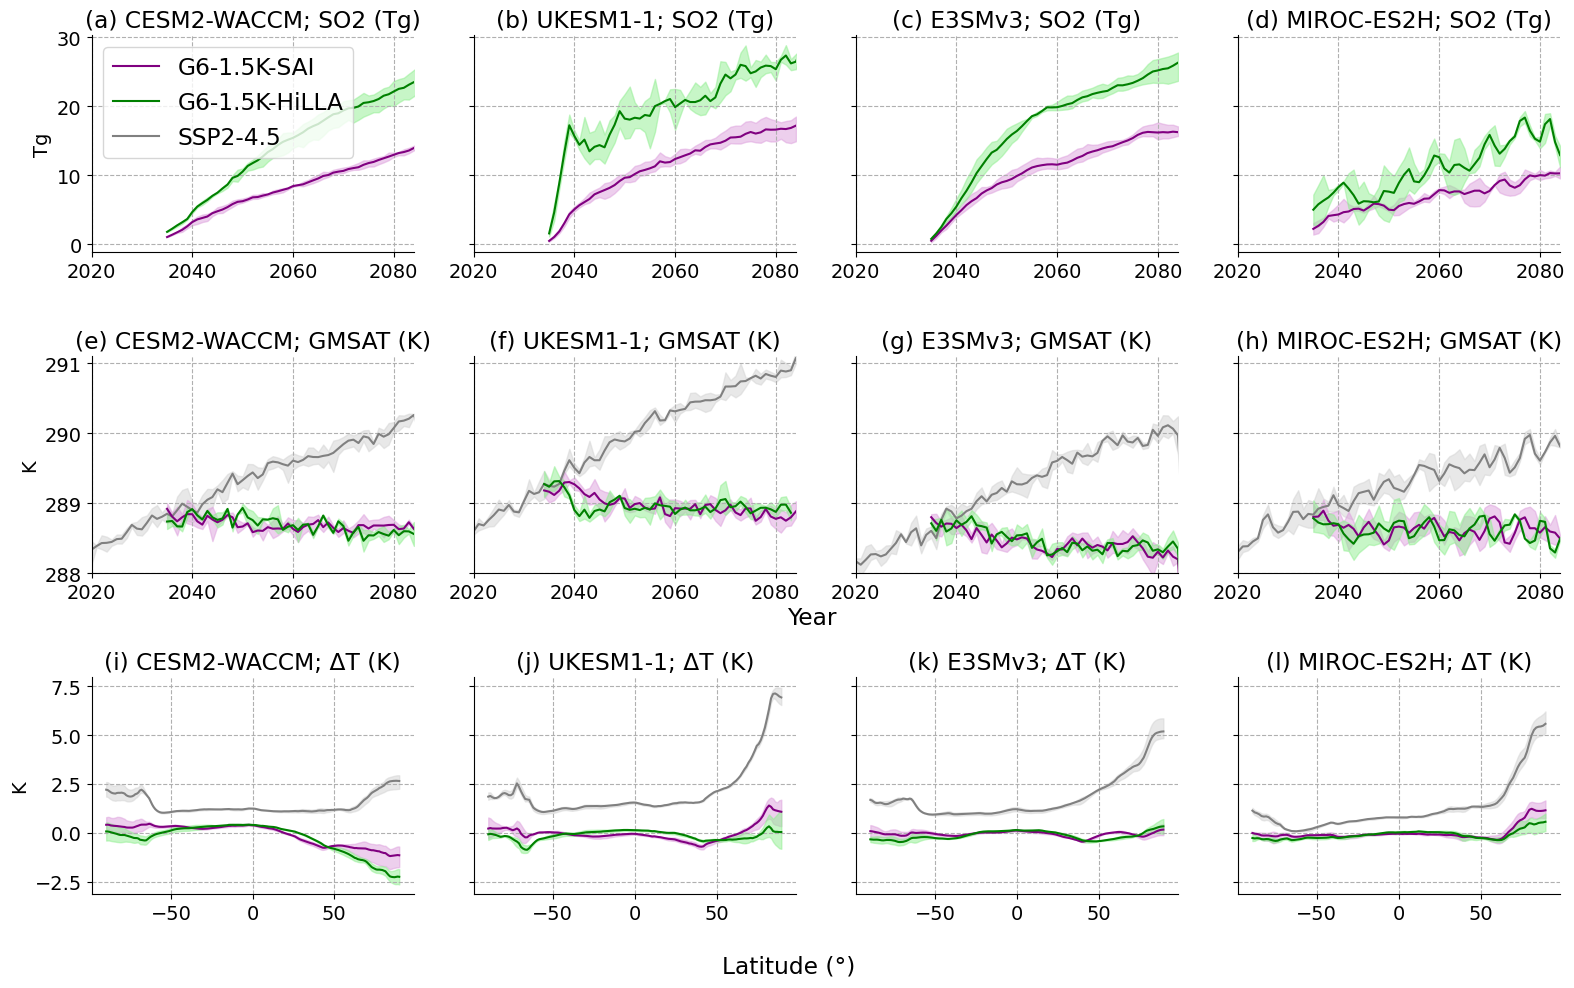

In [65]:
## MAIN FIG: 

# 
fig, axs = plt.subplots(3, 4, figsize=(16, 10), sharey='row')
t_col = 'black'

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
n=0
l=0
for model in ['CESM2-WACCM', 'UKESM1-1', 'E3SMv3', 'MIROC-ES2H']:
    ax = axs[0, l]
    for scenario in ['G6-1.5K-SAI', 'G6-1.5K-HiLLA']:
        inj_df = injection_timeseries_dict[model][scenario]
        ensemble_cols = ['r1 SO2 (Tg)', 'r2 SO2 (Tg)', 'r3 SO2 (Tg)']
        mean_vals = inj_df[ensemble_cols].mean(axis=1)
        min_vals = inj_df[ensemble_cols].min(axis=1)
        max_vals = inj_df[ensemble_cols].max(axis=1)
        years = inj_df['Timestamp']
        
        ax.plot(years, mean_vals, c=colours[scenario], label=scenario)
        ax.fill_between(years, 
                        min_vals, 
                        max_vals, 
                        color=colours['{}_light'.format(scenario)], alpha=0.5)
    #if l == 0:
    #    ax.legend()
    ax.set_xlim(2020, 2084)
    ax.set_title('{l} {m}; SO2 (Tg)'.format(l=labels[n], m=model))
    l=l+1
    n=n+1

    

l=0
for model in ['CESM2-WACCM', 'UKESM1-1', 'E3SMv3', 'MIROC-ES2H']:
    ax = axs[1, l]
    for scenario in ['SSP2-4.5', 'G6-1.5K-SAI', 'G6-1.5K-HiLLA']:
        ts = xr.concat(timeseries_dict[model][scenario], dim='Ensemble_member')
        ax.plot(ts.mean('Ensemble_member').time.dt.year.values, ts.mean('Ensemble_member').tas, c=colours[scenario], label=scenario)
        ax.fill_between(ts.isel(Ensemble_member=0).time.dt.year.values, 
                        ts.min('Ensemble_member').tas.values, 
                        ts.max('Ensemble_member').tas.values, 
                        color=colours['{}_light'.format(scenario)], alpha=0.5)
    #ax.legend()
    ax.set_title('{l} {m}; GMSAT (K)'.format(l=labels[n], m=model))
    ax.set_xlim(2020, 2084)
    ax.set_ylim(288, 291.1)
    l=l+1
    n=n+1



l=0
for model in ['CESM2-WACCM', 'UKESM1-1', 'E3SMv3', 'MIROC-ES2H']:
    ax = axs[2, l]
    for scenario in ['SSP2-4.5', 'G6-1.5K-SAI', 'G6-1.5K-HiLLA']:
        zm = zonal_means_dict[scenario][model]
        baseline = ssp245_baseline_zonal_mean_T_dict[model]

        # align naming conventions..
        if 'lat' in zm.dims:
            zm = zm.rename({'lat':'latitude'})
        if 'lat' in baseline.dims:
            baseline = baseline.rename({'lat':'latitude'})
            
        # check number of members and align on that too (because CESM HiLLA missing 1st member at the moment):
        num_mems = len(zm.Ensemble_member)
        baseline = baseline.isel(Ensemble_member=slice(0, num_mems))

        # get the change relative to baseline
        zm_anom = zm - baseline

        # plot
        ax.plot(zm_anom.mean('Ensemble_member').latitude.values, zm_anom.mean('Ensemble_member').tas, c=colours[scenario], label=scenario)
        ax.fill_between(zm_anom.isel(Ensemble_member=0).latitude.values, 
                        zm_anom.min('Ensemble_member').tas.values, 
                        zm_anom.max('Ensemble_member').tas.values, 
                        color=colours['{}_light'.format(scenario)], alpha=0.5)
   # ax.legend()
    ax.set_title('{l} {m}; ΔT (K)'.format(l=labels[n], m=model))
    l=l+1
    n=n+1



for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(ls='--')


axs[0,0].plot([], [], c=colours['SSP2-4.5'], label='SSP2-4.5')
axs[0,0].legend(fontsize='large')

axs[0,0].set_ylabel('Tg')
axs[1,0].set_ylabel('K')
axs[2,0].set_ylabel('K')

axs[1,1].set_xlabel('Year', fontsize='large')
axs[1,1].xaxis.set_label_coords(1.05, -0.15)

fig.supxlabel('Latitude (°)', fontsize='large')

plt.tight_layout()

plt.savefig('G6_SAIandHiLLA_overview_all.png', dpi=300)

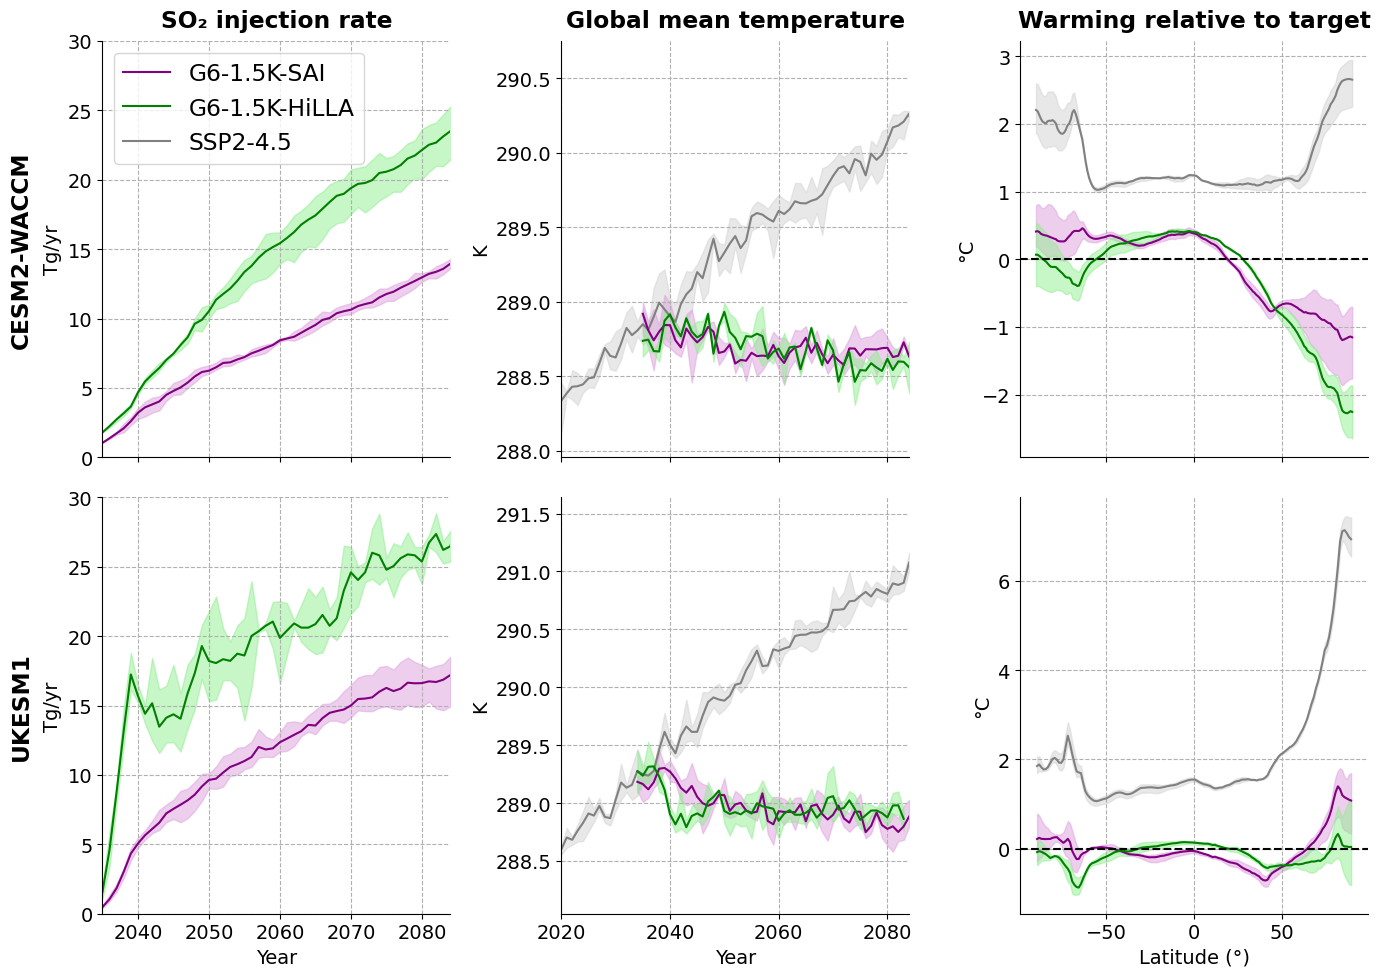

In [41]:
## also plot a fig with ukesm and cesm, organised the other way round: 

# 
fig, axs = plt.subplots(2, 3, figsize=(14, 10), sharex='col')
t_col = 'black'


l=0
for model in ['CESM2-WACCM', 'UKESM1-1']:
    ax = axs[l, 0]
    for scenario in ['G6-1.5K-SAI', 'G6-1.5K-HiLLA']:
        inj_df = injection_timeseries_dict[model][scenario]
        ensemble_cols = ['r1 SO2 (Tg)', 'r2 SO2 (Tg)', 'r3 SO2 (Tg)']
        mean_vals = inj_df[ensemble_cols].mean(axis=1)
        min_vals = inj_df[ensemble_cols].min(axis=1)
        max_vals = inj_df[ensemble_cols].max(axis=1)
        years = inj_df['Timestamp']
        
        ax.plot(years, mean_vals, c=colours[scenario], label=scenario)
        ax.fill_between(years, 
                        min_vals, 
                        max_vals, 
                        color=colours['{}_light'.format(scenario)], alpha=0.5)
    #if l == 0:
    #    ax.legend()
    ax.set_xlim(2035, 2084)
    ax.set_ylim(0, 30)
    #ax.set_title('{}; SO2 (Tg)'.format(model))
    l=l+1

    

l=0
for model in ['CESM2-WACCM', 'UKESM1-1']:
    ax = axs[l, 1]
    for scenario in ['SSP2-4.5', 'G6-1.5K-SAI', 'G6-1.5K-HiLLA']:
        ts = xr.concat(timeseries_dict[model][scenario], dim='Ensemble_member')
        ax.plot(ts.mean('Ensemble_member').time.dt.year.values, ts.mean('Ensemble_member').tas, c=colours[scenario], label=scenario)
        ax.fill_between(ts.isel(Ensemble_member=0).time.dt.year.values, 
                        ts.min('Ensemble_member').tas.values, 
                        ts.max('Ensemble_member').tas.values, 
                        color=colours['{}_light'.format(scenario)], alpha=0.5)
    #ax.legend()
    #ax.set_title('{}; GMSAT (K)'.format(model))
    ax.set_xlim(2020, 2084)
    l=l+1



l=0
for model in ['CESM2-WACCM', 'UKESM1-1']:
    ax = axs[l, 2]
    for scenario in ['SSP2-4.5', 'G6-1.5K-SAI', 'G6-1.5K-HiLLA']:
        zm = zonal_means_dict[scenario][model]
        baseline = ssp245_baseline_zonal_mean_T_dict[model]

        # align naming conventions..
        if 'lat' in zm.dims:
            zm = zm.rename({'lat':'latitude'})
        if 'lat' in baseline.dims:
            baseline = baseline.rename({'lat':'latitude'})
            
        # check number of members and align on that too (because CESM HiLLA missing 1st member at the moment):
        num_mems = len(zm.Ensemble_member)
        baseline = baseline.isel(Ensemble_member=slice(0, num_mems))

        # get the change relative to baseline
        zm_anom = zm - baseline

        # plot
        ax.plot(zm_anom.mean('Ensemble_member').latitude.values, zm_anom.mean('Ensemble_member').tas, c=colours[scenario], label=scenario)
        ax.fill_between(zm_anom.isel(Ensemble_member=0).latitude.values, 
                        zm_anom.min('Ensemble_member').tas.values, 
                        zm_anom.max('Ensemble_member').tas.values, 
                        color=colours['{}_light'.format(scenario)], alpha=0.5) 
    ax.axhline(c='black', y=0, ls='--')
    #ax.set_title('{}; GMSAT (K)'.format(model))
    l=l+1


axs[0,0].plot([], [], c=colours['SSP2-4.5'], label='SSP2-4.5')
axs[0,0].legend(fontsize='large')

for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(ls='--')


axs[0,0].set_ylabel('Tg/yr')
axs[1,0].set_ylabel('Tg/yr')
axs[1,0].set_xlabel('Year')

axs[0,1].set_ylabel('K')
axs[1,1].set_ylabel('K')
axs[1,1].set_xlabel('Year')

axs[0,2].set_ylabel('°C')
axs[1,2].set_ylabel('°C')
axs[1,2].set_xlabel('Latitude (°)')

axs[0, 0].set_title('SO₂ injection rate', fontsize='large', fontweight='bold', pad=10)
axs[0, 1].set_title('Global mean temperature', fontsize='large', fontweight='bold', pad=10)
axs[0, 2].set_title('Warming relative to target', fontsize='large', fontweight='bold', pad=10)

for i in [0,1]:
    axs[i, 0].annotate(
            ['CESM2-WACCM', 'UKESM1'][i], 
            xy=(0, 0.5),                    
            xycoords='axes fraction',       
            xytext=(-50, 0),                # Shift 40 points to the left
            textcoords='offset points', 
            ha='right', va='center',        # Alignment
            fontsize='large', fontweight='bold', # Large and bold
            rotation=90                      # Horizontal text
        )

#fig.text(-0.06, 0.9, 'CESM2-\nWACCM', va='center', rotation='horizontal', fontsize='x-large', fontweight='bold')
#fig.text(-0.06, 0.45, 'UKESM1', va='center', rotation='horizontal', fontsize='x-large', fontweight='bold')

plt.tight_layout()

plt.savefig('G6_SAIandHiLLA_overview_all_landscape.png', dpi=300, bbox_inches='tight')

In [1]:
## also print some output values, for ratio of efficiencies 


In [76]:
for model in ['CESM2-WACCM', 'UKESM1-1', 'E3SMv3', 'MIROC-ES2H']:
    print(model)
    vals=[]
    for scenario in ['G6-1.5K-SAI', 'G6-1.5K-HiLLA']:
        inj_df = injection_timeseries_dict[model][scenario]
        ensemble_cols = ['r1 SO2 (Tg)', 'r2 SO2 (Tg)', 'r3 SO2 (Tg)']
        inj_df = inj_df[inj_df['Timestamp']>assessment_years[0]]
        inj_df = inj_df[inj_df['Timestamp']<=assessment_years[1]]
        inj_df = inj_df[ensemble_cols].mean(axis=1)
        val = inj_df.mean()
        vals.append(val)
        #mean_vals = inj_df[ensemble_cols].mean(axis=1)
        print(val)
    print('SAI uses '+str(np.round(100*vals[0]/vals[1]))+'% of HiLLA SO2')
    print('HiLLA uses '+str(np.round(vals[1]/vals[0], 3))+'x SAI SO2')
    print('HiLLA has '+str(np.round(100*(1/vals[1]) / (1/vals[0])))+'% of SAI cooling efficiency')

CESM2-WACCM
11.568077813961793
20.36471844908666
SAI uses 57.0% of HiLLA SO2
HiLLA uses 1.76x SAI SO2
HiLLA has 57.0% of SAI cooling efficiency
UKESM1-1
15.666314098947366
24.50294410245614
SAI uses 64.0% of HiLLA SO2
HiLLA uses 1.564x SAI SO2
HiLLA has 64.0% of SAI cooling efficiency
E3SMv3
14.968296334788521
23.445693538328
SAI uses 64.0% of HiLLA SO2
HiLLA uses 1.566x SAI SO2
HiLLA has 64.0% of SAI cooling efficiency
MIROC-ES2H
8.817396082105263
14.800579064912279
SAI uses 60.0% of HiLLA SO2
HiLLA uses 1.679x SAI SO2
HiLLA has 60.0% of SAI cooling efficiency
